In [2]:
from __future__ import division, print_function, absolute_import

import tmm
import math
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

from enum import Enum
from typing import NamedTuple

from tmm_fast import coh_tmm

In [3]:
parameters_t = np.dtype([
    ("f_k", "f4"),
    ("n_k", "f4"),
    ("f_m", "f4"),
    ("n_m", "f4"),
    ("k_m", "c8"),
    ("f_a", "f4"),
    ("n_a", "f4"),
])

In [4]:
class Material(Enum):
    KERATIN = 1
    MELANIN_MEMBRANE = 2
    MELANIN_INTERNAL = 3
    AIR = 4

In [5]:
def cauchy(A, B, wavelengths):
    return A + B*wavelengths**-2

def melanin_imaginary(wavelengths):
    a_m = 0.56
    b_m = 270
    return a_m * np.exp(-wavelengths / b_m) * 1.0j

def keratin_index(wavelengths):
    A_k = 1.532
    B_k = 5890
    return cauchy(A_k, B_k, wavelengths)

def melanin_index(wavelengths):
    A_m = 1.648
    B_m = 23700
    return cauchy(A_m, B_m, wavelengths)

In [6]:
def calc_keratin_layer(wavelengths):
    parameters = np.zeros(wavelengths.shape, dtype=parameters_t)
    parameters["f_k"] = 1
    parameters["n_k"] = keratin_index(wavelengths)
    parameters["f_m"] = 0
    parameters["n_m"] = 0
    parameters["k_m"] = 0
    parameters["f_a"] = 0
    parameters["n_a"] = 0
    return parameters

In [7]:
def calc_melanin_layer(wavelengths):
    parameters = np.zeros(wavelengths.shape, dtype=parameters_t)
    parameters["f_k"] = 0
    parameters["n_k"] = 0
    parameters["f_m"] = 1
    parameters["n_m"] = melanin_index(wavelengths)
    parameters["k_m"] = melanin_imaginary(wavelengths)
    parameters["f_a"] = 0
    parameters["n_a"] = 0
    return parameters

In [8]:
def calc_melanosome_internal_layer_index(wavelengths):
    parameters = np.zeros(wavelengths.shape, dtype=parameters_t)
    parameters["f_k"] = 0.05
    parameters["n_k"] = keratin_index(wavelengths)
    parameters["f_m"] = 0.4
    parameters["n_m"] = melanin_index(wavelengths)
    parameters["k_m"] = melanin_imaginary(wavelengths)
    parameters["f_a"] = 0.55
    parameters["n_a"] = 1
    return parameters

In [9]:
def calc_refractive_index(parameters):
    n_eff = (
        parameters["f_k"] * parameters["n_k"]
        + parameters["f_m"] * (parameters["n_m"] + parameters["k_m"])
        + parameters["f_a"] * parameters["n_a"]
    )

    return n_eff

In [10]:
def calc_layers(wavelengths):
    # Thicknesses in nm
    keratin_cortex_thickness = 5
    keratin_separation_thickness = 50
    melanosome_membrane_thickness = 30
    # Note: this can be changed to adjust periodicity
    melanosome_internal_thickness = 100
    top_melanosome_internal_thickness = 50

    air_layer_indices = np.ones(wavelengths.shape)
    keratin_layer_indices = calc_refractive_index(calc_keratin_layer(wavelengths))
    melanosome_membrane_indices = calc_refractive_index(calc_melanin_layer(wavelengths))
    melanosome_internal_indices = calc_refractive_index(calc_melanosome_internal_layer_index(wavelengths))

    # Init layers to first infinite air layer
    layers = [[Material.AIR, np.inf]]

    # Add keratin cortex layer
    layers.append([Material.KERATIN, keratin_cortex_thickness])

    # Add top melanosome layer
    layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])
    layers.append([Material.MELANIN_INTERNAL, top_melanosome_internal_thickness])
    layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])

    # Add the rest of the keratin separation and melanosome layers
    melanosome_layers = 12
    melanosome_layers -= 1  # Because of the top melanosome layer
    for _ in range(melanosome_layers):
        layers.append([Material.KERATIN, keratin_separation_thickness])
        layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])
        layers.append([Material.MELANIN_INTERNAL, melanosome_internal_thickness])
        layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])

    # Add keratin cortex layer
    layers.append([Material.KERATIN, keratin_cortex_thickness])

    # Add last infinite air layer
    layers.append([Material.AIR, np.inf])

    layers = np.array(layers)

    layers_indices = np.empty((layers.shape[0], wavelengths.size), dtype=np.complex64)
    layers_indices[layers[:, 0] == Material.AIR] = air_layer_indices
    layers_indices[layers[:, 0] == Material.KERATIN] = keratin_layer_indices
    layers_indices[layers[:, 0] == Material.MELANIN_MEMBRANE] = melanosome_membrane_indices
    layers_indices[layers[:, 0] == Material.MELANIN_INTERNAL] = melanosome_internal_indices

    return layers[:, 1], layers_indices

/home/wet-dog/repos/tmm_fast/tmm_fast/vectorized_tmm_dispersive_multistack.py:165: UserWarning: Opacity warning. The imaginary part of the refractive index is clamped to 35i for numerical stability.
You might encounter problems with gradient computation...
  warn(


Text(0.5, 1.0, 'Reflectance at normal incidence')

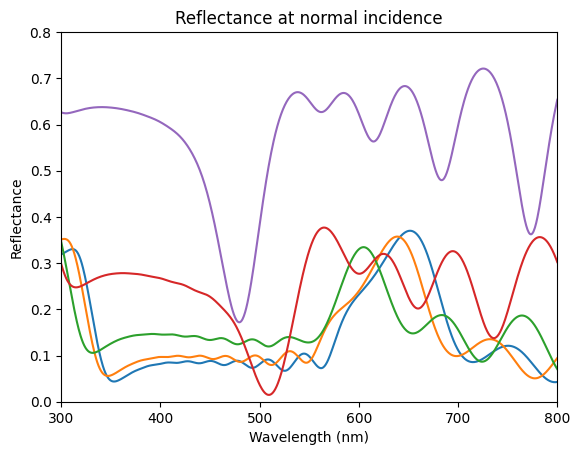

In [11]:
wavelengths = np.linspace(300, 800, 800)
thetas = np.deg2rad(np.arange(0, 90, 20))

d_list, n_list = calc_layers(wavelengths)

d_list = np.expand_dims(d_list, axis=0).astype(np.float32)
n_list = np.expand_dims(n_list, axis=0)

polarization = "s"
O = coh_tmm(polarization, n_list, d_list, thetas, wavelengths, device="cpu")

plt.figure()

for i in range(thetas.shape[0]):
    plt.plot(wavelengths, O["R"][0, i, :])

plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.xlim(300, 800)
plt.ylim(0, 0.8)
plt.title("Reflectance at normal incidence")

In [12]:
# results = []
# wavelength_count = 10000000
# optimal_count = 1
# divisor = wavelength_count // optimal_count
# step = wavelength_count // divisor
# wavelengths_total = np.linspace(300, 800, wavelength_count)
# for i in range(divisor):
#     start = step * i
#     end = step * (i + 1)

#     if i == divisor - 1:
#         end = wavelengths_total.size

#     print(start, end)

#     wavelengths = wavelengths_total[start:end]
#     thetas = np.deg2rad([0])

#     d_list, n_list = calc_layers(wavelengths)

#     d_list = np.expand_dims(d_list, axis=0).astype(np.float32)
#     n_list = np.expand_dims(n_list, axis=0)

#     polarization = "s"
#     O = coh_tmm(polarization, n_list, d_list, thetas, wavelengths, device="cuda")

#     results.extend(O["R"].ravel())

# print("Collected results:")
# results = np.array(results)
# print(results.size)
# print(results)